Shape: (16, 3)


,Person,AVG Reaction Time,Accuracy
0,1st,1.05,98.30%
1,2nd,1.50,97.50%
2,3rd,1.34,97.80%
3,4th,1.39,97.50%
4,5th,1.57,96.70%
5,6th,1.07,98.20%
6,7th,1.65,97.30%
7,8th,1.08,98.50%
8,9th,1.79,96.80%
9,10th,1.22,98.00%


Numeric feature count: 1
Best k: 3 (Silhouette=0.5096)


,Person,AVG Reaction Time,Accuracy,cluster_label
0,1st,1.05,98.30%,2
1,2nd,1.50,97.50%,0
2,3rd,1.34,97.80%,0
3,4th,1.39,97.50%,0
4,5th,1.57,96.70%,0
5,6th,1.07,98.20%,2
6,7th,1.65,97.30%,1
7,8th,1.08,98.50%,2
8,9th,1.79,96.80%,1
9,10th,1.22,98.00%,2


Train/Test sizes: (12, 1) (4, 1)
Class distribution in train: {0: 7, 1: 2, 2: 3}
Class distribution in test: {0: 2, 1: 1, 2: 1}
SVM Accuracy: 0.75
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.00      0.00      0.00         1
           2       1.00      1.00      1.00         1

    accuracy                           0.75         4
   macro avg       0.56      0.67      0.60         4
weighted avg       0.58      0.75      0.65         4



<Figure size 640x480 with 0 Axes>

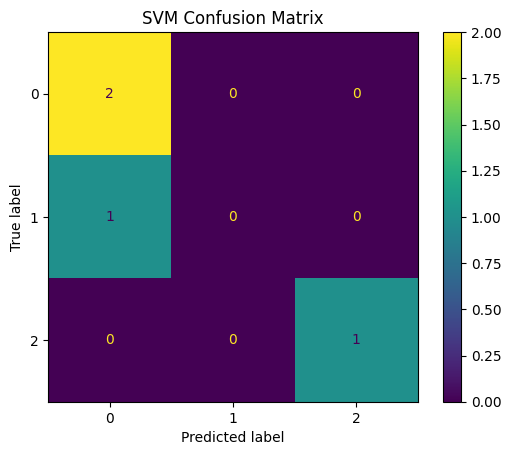

Decision Tree Accuracy: 1.0
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



<Figure size 640x480 with 0 Axes>

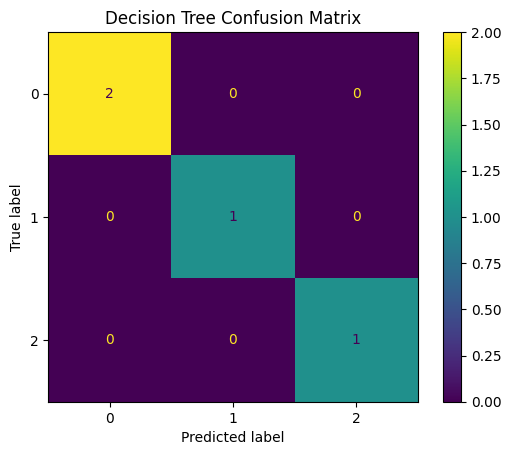

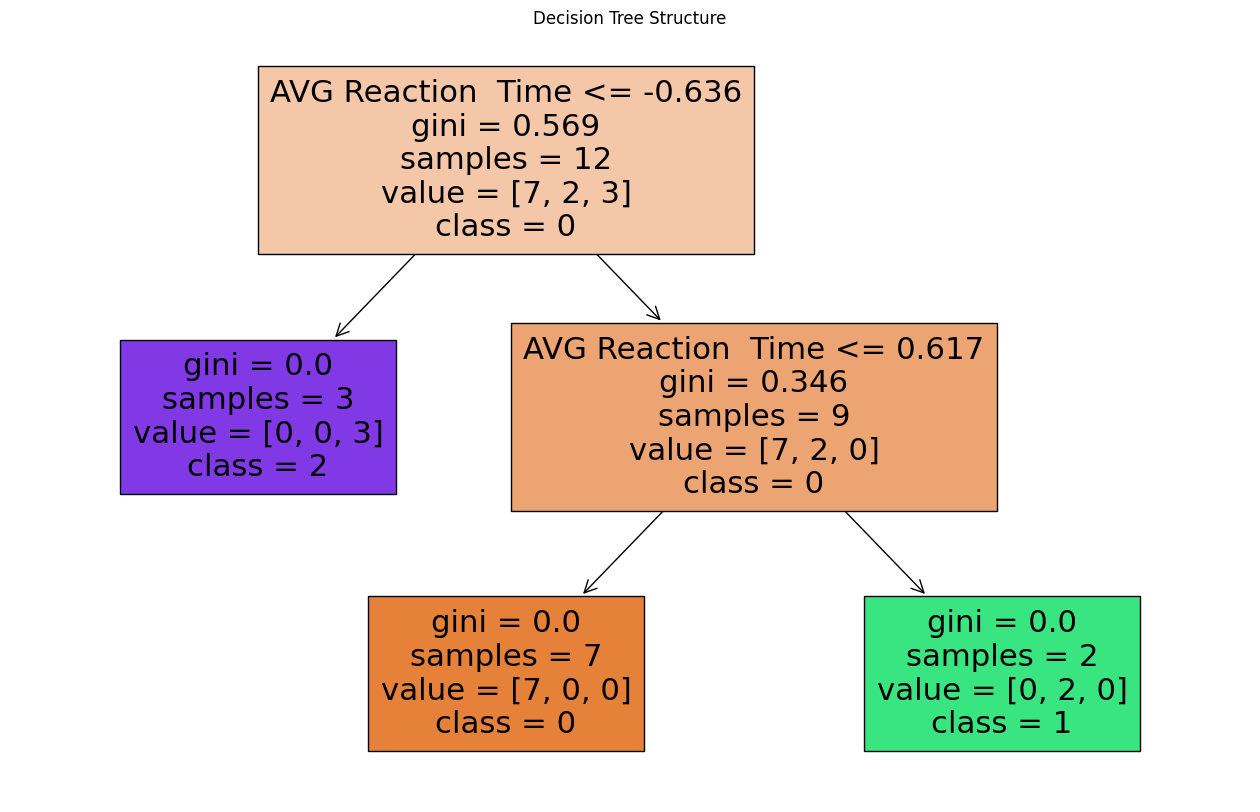

Saved clustered dataset to: E:\North South University\Semester 10\CSE445\Mini_Project_1\output\clustered_output.csv
Saved models to project folder.


In [ ]:
# Core imports
import os
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import joblib


# Ensure pandas shows all rows
pd.set_option('display.max_rows', None)

# Define file paths (Improved for portability)

base_dir = r"E:\North South University\Semester 10\CSE445\Mini_Project_1"
csv_path = os.path.join(base_dir, "data.csv")
output_dir = os.path.join(base_dir, "output")
os.makedirs(output_dir, exist_ok=True) # Ensure output directory exists


# Load dataset

if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CSV not found at: {csv_path}")

df = pd.read_csv(csv_path)
print("Shape:", df.shape)
display(df)


# Numeric preprocessing

numeric_df = df.select_dtypes(include=[np.number]).copy()
if numeric_df.shape[1] == 0:
    raise ValueError("No numeric columns found.")

# Impute missing values and scale
imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()
X_num = imputer.fit_transform(numeric_df)
X_scaled = scaler.fit_transform(X_num)
print("Numeric feature count:", numeric_df.shape[1])


# Find best k with silhouette, ensuring at least 2 samples per cluster

best_k, best_labels, best_score = None, None, -1
for k_try in range(2, min(10, len(X_scaled)) + 1):
    km = KMeans(n_clusters=k_try, n_init=10, random_state=42)
    labels = km.fit_predict(X_scaled)
    counts = np.bincount(labels)
    if min(counts) < 2:
        continue  # skip if any cluster has < 2 samples
    try:
        score = silhouette_score(X_scaled, labels)
        if score > best_score:
            best_k, best_labels, best_score = k_try, labels, score
    except:
        continue

if best_k is None:
    best_k = 2
    km = KMeans(n_clusters=best_k, n_init=10, random_state=42)
    best_labels = km.fit_predict(X_scaled)
    print("Silhouette search failed; falling back to k=2.")
else:
    print(f"Best k: {best_k} (Silhouette={best_score:.4f})")

cluster_labels = best_labels
df_with_labels = df.copy()
df_with_labels["cluster_label"] = cluster_labels
display(df_with_labels)

# Train/Test split

X = X_scaled
y = cluster_labels

# For very small datasets, skip stratify if needed
stratify_labels = y if min(np.bincount(y)) >= 2 else None
test_size = 0.25 if len(X) >= 8 else 0.33

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=42, stratify=stratify_labels
)

print("Train/Test sizes:", X_train.shape, X_test.shape)
print("Class distribution in train:", {c:int((y_train==c).sum()) for c in np.unique(y_train)})
print("Class distribution in test:", {c:int((y_test==c).sum()) for c in np.unique(y_test)})


# Train SVM

svm_clf = SVC(kernel="rbf", gamma="scale", C=1.0, random_state=42)
svm_clf.fit(X_train, y_train)
svm_pred = svm_clf.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, svm_pred))
print("SVM Classification Report:\n", classification_report(y_test, svm_pred, zero_division=0))

cm_svm = confusion_matrix(y_test, svm_pred, labels=np.sort(np.unique(y)))
disp_svm = ConfusionMatrixDisplay(cm_svm, display_labels=np.sort(np.unique(y)))
plt.figure()
disp_svm.plot(values_format="d")
plt.title("SVM Confusion Matrix")
plt.show()


# Train Decision Tree

dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, dt_pred))
print("Decision Tree Classification Report:\n", classification_report(y_test, dt_pred, zero_division=0))

cm_dt = confusion_matrix(y_test, dt_pred, labels=np.sort(np.unique(y)))
disp_dt = ConfusionMatrixDisplay(cm_dt, display_labels=np.sort(np.unique(y)))
plt.figure()
disp_dt.plot(values_format="d")
plt.title("Decision Tree Confusion Matrix")
plt.show()

# Plot Decision Tree
plt.figure(figsize=(16, 10))
plot_tree(
    dt_clf,
    filled=True,
    feature_names=numeric_df.columns.tolist(),
    class_names=[str(c) for c in sorted(np.unique(y))]
)
plt.title("Decision Tree Structure")
plt.show()

# PCA 2D cluster visualization (Improved line/marker config)

if X_scaled.shape[1] > 1:
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    plt.figure(figsize=(8,6))
    
    # Define a list of markers to use for each cluster
    markers = ['o', 's', '^', 'D', 'X', 'P']
    
    for i, c in enumerate(np.unique(y)):
        # Added marker, size, and alpha (transparency) options
        plt.scatter(
            X_pca[y==c,0], 
            X_pca[y==c,1], 
            label=f"Cluster {c}",
            marker=markers[i % len(markers)], # Cycle through different markers
            s=50,                            # Set marker size
            alpha=0.8                        # Set transparency
        )

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("PCA 2D Cluster Visualization")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6) # Add a dashed grid
    plt.show()

# Save outputs

out_csv = os.path.join(output_dir, "clustered_output.csv")
df_with_labels.to_csv(out_csv, index=False)
print(f"Saved clustered dataset to: {out_csv}")

joblib.dump(svm_clf, os.path.join(output_dir, "svm_model.joblib"))
joblib.dump(dt_clf, os.path.join(output_dir, "decision_tree_model.joblib"))
joblib.dump(km, os.path.join(output_dir, "kmeans_model.joblib"))
print("Saved models to project folder.")